In [1]:
! pip install -q openai==1.68.1 \
                 langchain \
                 langchain-openai \
                 langgraph \
                 chromadb \
                 langchain-chroma \
                 duckduckgo-search \
                 langchain_community\
                 langchain_experimental


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip uninstall -y numpy
!pip install numpy==1.23.5

Found existing installation: numpy 2.3.5
Uninstalling numpy-2.3.5:
  Successfully uninstalled numpy-2.3.5
  Using cached numpy-1.23.5.tar.gz (10.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [33 lines of output]
      Traceback (most recent call last):
        File "/Users/shugney20/Documents/genai/.venv/lib/python3.12/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 389, in <module>
          main()
        File "/Users/shugney20/Documents/genai/.venv/lib/python3.12/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 373, in main
          json_out["return_val"] = hook(**hook_input["kwargs"])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "/Users/shugney20/Documents/genai/.venv/lib/python3.12/site-packages/pip/_vendor/pyproject_h

In [3]:
!pip install gradio

  Using cached numpy-2.3.5-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
Using cached numpy-2.3.5-cp312-cp312-macosx_14_0_arm64.whl (5.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.3.5 which is incompatible.
scipy 1.13.1 requires numpy<2.3,>=1.22.4, but you have numpy 2.3.5 which is incompatible.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [4]:
!pip show langgraph

Name: langgraph
Version: 1.0.1
Summary: Building stateful, multi-actor applications with LLMs
Home-page: 
Author: 
Author-email: 
License-Expression: MIT
Location: /Users/shugney20/Documents/genai/.venv/lib/python3.12/site-packages
Requires: langchain-core, langgraph-checkpoint, langgraph-prebuilt, langgraph-sdk, pydantic, xxhash
Required-by: 


In [5]:
import os
import re
import json
import uuid
import logging
import sqlite3
import requests
import time
import random
from bs4 import BeautifulSoup
from typing import List, Optional, Dict

from pydantic import BaseModel, Field, ValidationError
from duckduckgo_search import DDGS

from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.memory import ConversationBufferMemory
from langchain.sql_database import SQLDatabase
from langchain.tools import QuerySQLDataBaseTool, tool
from langchain_experimental.sql import SQLDatabaseChain
from langchain.agents import initialize_agent, create_sql_agent, AgentType
from langgraph.graph import END, StateGraph
import langgraph
from langchain_core.runnables.config import RunnableConfig
from langchain_core.runnables.utils import AddableDict as AddableValuesDict

import gradio as gr

from langsmith import traceable, Client


langgraph_config = RunnableConfig(recursion_limit=100, run_tree = True)

logging.basicConfig(level = logging.INFO)


/Users/shugney20/Documents/genai/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:

file_name = "../config.json"
with open(file_name, "r") as file:
    config = json.load(file)
    API_KEY = config.get("API_KEY")
    OPENAI_API_BASE = config.get("OPENAI_API_BASE")

In [9]:
os.environ['OPENAI_API_KEY'] = API_KEY
os.environ['OPENAI_API_BASE'] = OPENAI_API_BASE

In [10]:
llm_high = ChatOpenAI(model_name = "gpt-4o-mini", temperature = 0.7)
llm_low = ChatOpenAI(model_name = "gpt-4o-mini", temperature = 0)

# Check LLM Response

In [11]:
for i in range(10):
    response = llm_low.predict("Hello, how are you")
    print(response)

/var/folders/3f/dl8h79md0tl8wg6wq4rmkpdw0000gq/T/ipykernel_95102/1637906545.py:2: LangChainDeprecationWarning: The method `BaseChatModel.predict` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm_low.predict("Hello, how are you")
INFO:httpx:HTTP Request: POST https://aibe.mygreatlearning.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


INFO:httpx:HTTP Request: POST https://aibe.mygreatlearning.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


INFO:httpx:HTTP Request: POST https://aibe.mygreatlearning.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


INFO:httpx:HTTP Request: POST https://aibe.mygreatlearning.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


INFO:httpx:HTTP Request: POST https://aibe.mygreatlearning.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


INFO:httpx:HTTP Request: POST https://aibe.mygreatlearning.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


INFO:httpx:HTTP Request: POST https://aibe.mygreatlearning.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


INFO:httpx:HTTP Request: POST https://aibe.mygreatlearning.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


INFO:httpx:HTTP Request: POST https://aibe.mygreatlearning.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


INFO:httpx:HTTP Request: POST https://aibe.mygreatlearning.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


In [12]:
for i in range(10):
    response = llm_high.predict("Hello, how are you")
    print(response)

INFO:httpx:HTTP Request: POST https://aibe.mygreatlearning.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


INFO:httpx:HTTP Request: POST https://aibe.mygreatlearning.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


INFO:httpx:HTTP Request: POST https://aibe.mygreatlearning.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


INFO:httpx:HTTP Request: POST https://aibe.mygreatlearning.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


INFO:httpx:HTTP Request: POST https://aibe.mygreatlearning.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


INFO:httpx:HTTP Request: POST https://aibe.mygreatlearning.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


INFO:httpx:HTTP Request: POST https://aibe.mygreatlearning.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


INFO:httpx:HTTP Request: POST https://aibe.mygreatlearning.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


INFO:httpx:HTTP Request: POST https://aibe.mygreatlearning.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


INFO:httpx:HTTP Request: POST https://aibe.mygreatlearning.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


# Defining the State Schema for the LangGraph Workflow

In [15]:
# class CustomerState(BaseModel):
#     email: Optional[str] = None
#     name: Optional[str] = None
#     interests: Optional[str] = None
#     email_found: bool = False
#     customer_id: Optional[str] = None
#     expanded_search: List[str] = []
#     search_results: List[Dict[str, str]] = []
#     credible_urls: List[Dict[str, str]] = []
#     max_results: int = 7
#     #filtered_urls: List[Dict[str, str]] = []
#     info: List[str] = []

class CustomerStateV2(BaseModel):
    email: Optional[str] = None
    name: Optional[str] = None
    interests: Optional[str] = None
    email_found: bool = False
    customer_id: Optional[str] = None
    expanded_search: List[str] = []
    search_results: List[Dict[str, str]] = []
    credible_urls: List[Dict[str, str]] = []
    max_results: int = 7
    filtered_urls: List[Dict[str, str]] = []
    info: List[Dict[str, str]] = Field(default_factory=list)

In [18]:
test_data = {
    "filtered_urls": [
        {"url": "https://ww.msn.com"},
        {"url": "https://www.economist.com"}
    ]
}

state = CustomerStateV2(**test_data)
print(state)

email=None name=None interests=None email_found=False customer_id=None expanded_search=[] search_results=[] credible_urls=[] max_results=7 filtered_urls=[{'url': 'https://ww.msn.com'}, {'url': 'https://www.economist.com'}] info=[]


# SQL Agent for Data Retrieval and Customer Information Update

In [19]:
# initialize sql agent with system message
def setup_sql_agent():
    db = SQLDatabase.from_uri("sqlite:///customer.db")

    sys_msg = "You are an AI-powered SQL Assistant. Your role is to retrieve or inset structured data into the database efiiciently and accuracetly. And return no result foundif not able to retrieve data"

    # define sql query tool
    sql_tool = QuerySQLDataBaseTool(db = db)

    # init agent with sys msg
    sql_agent = initialize_agent(
        tools = [sql_tool],
        llm = llm_low,
        agent = AgentType.ZERO_SHOT_REACT_DESCRIPTION,
        verbose = True,
        memory = ConversationBufferMemory(),
        system_message = sys_msg.strip()
    )

    return sql_agent

# email retrieval and validaiton in customer state
def ask_email(state: CustomerStateV2):
    """Retrieve email from state or prompt user if missing""" 
    if not state.email:
        state.email = input("enter your email ID: ").strip().lower()
    
    return {"email": state.email}

In [ ]:
def check_email(state: CustomerStateV2):
    """ 
    Queries the database for customer details using the provided email ID. 
    Extracts ID, Name, Email, and Interests. If no result is found, email_found is set to False.
    """ 
    query = f"""
    Extract ID, Name, Email, and Interests information from the database for the email ID '{state.email}' 
    Always return responses with the following fields:
    - ID
    - Name 
    - Email 
    - Interests 
    return no result found if not able to retrieve data
    """ 
    # Execute query and strip result
    sql_agent = setup_sql_agent()
    result = sql_agent.run(query)

    # Exit if not results found
    match = re.search(r"\bno\s+(result|results|record|records)\b", result, re.IGNORECASE)

    if match:
        state.email_found = False
        return {"email_found": False}
    interests_match = re.search(r"Interests:\s*(.+)", result)
    interests = [i.strip() for i in interests_match.group(1).split(",")] if interests_match else []

    try:
        name_match = re.search(r"Name:\s*(.+)", result)
        name = name_match.group(1).strip() if name_match else None

        state.name = name
        state.interests = ", ".join(interests)
        state.email_found = True

        return {
            "email_found": True,
            "name": state.name,
            "interests": state.interests
        }
    except (json.JSONDecodeError, TypeError) as e:
        logging.error(f"Failed to parse cubstomer data: {result} - Error: {str(e)}")
        state.email_found = False
        return {"email_found": False}

In [21]:
def ask_and_add_details(state: CustomerStateV2):
    def generate_customer_id():
        return str(uuid.uuid())[:10].upper()
    print("Your email is not in the database.")
    if not state.name:
        name = input("Enter your name: ").strip()
    else:
        name = state.name
    customer_id = generate_customer_id()

    while True:
        if not state.interests:
          interests = input(f"Select at least one interest (comma-separated): ").strip()
        else:
          interests=state.interests
        embed_interests = [i.strip() for i in interests.split(",")]
        if embed_interests:
            break
        print("❌ Please Enter at least one interest.")
    
    query = f"""INSERT INTO customers (customer_id, name, email, interests)
                VALUES ('{customer_id}', '{name}', '{state.email}', '{embed_interests}')"""
    sql_agent = setup_sql_agent()

    sql_agent.run(query)

    return {"email_found": True, "customer_id": customer_id, "name": name, "interests": interests}
    

In [22]:
# Show interests
def show_interests(state: CustomerStateV2):
    interests_str = state.interests
    return {"message": f"Hello {state.name}, your interests are {interests_str}."}

In [28]:
def expand_search_queries(state: CustomerStateV2):
    """ 
    Use the core LLM to expand each user interest into a related search query
    """ 
    print("--- Expand Search Queryies")

    system_prompt = f"""You are an expert news analyst specializing in crafting precise search queries to retrieve the most recent, up-to-date information.
    Your task is to generate on ** relevant and time-sensitive** search query for each provided interest, ensuring the results focus on **breaking news, trending topics, or recent developments** only.

    - Do **not** include any specific year in the query.
    - Format queries to prioritize **current news** while avoiding outdated information.
    - Ensure the queries remain natural and relevant without relying on explicit date mentions.
    """
    expanded_queries = []
    mid_interest = state.interests
    interests = mid_interest.split(', ')
    for interest in interests:
        prompt = f"Generate one search query related to; '{interest}'"

        response = llm_low.invoke(
            [
                SystemMessage(content = system_prompt),
                HumanMessage(content = prompt)
            ]
        )

        query = response.content.strip()
        if query:
            expanded_queries.append(query)

    print("Expanded Search Queries:\n", expanded_queries)

    return {"expanded_search": expanded_queries}

def clean_text(text):
    cleaned = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return ' '.join(cleaned.split())
    

In [23]:
def get_duckduckgo_results(state: CustomerStateV2):
    print("--- Getting DuckDuckGo Results ----")
    search_results = []

    for query in state.expanded_search:
        clean_query = clean_text(query)

        if not clean_query:
            print(f"skipping invalid pair: {query}")
            continue

        print(f"searching for: {clean_query}")

        with DDGS() as ddgs:
            while len(search_results) < 5:
                results = list(ddgs.news(clean_query, max_results=state.max_results))
                print(f"Raw Response for '{clean_query}': {results}")

                if not results or any("google.com" in r.get("url", "") for r in results):
                    print(f"Warning Potential API issue or DDG blocking request for '{clean_query}")
                    continue

                search_results.extend(results)

                wait_time = random.uniform(2, 5)
                print(f" Waiting {wait_time:.2f} seconds before next request...")
                time.sleep(wait_time)

    print(search_results)
    return {"search_results": search_results}


In [24]:
def filter_urls(state: CustomerStateV2):
    """
    Filters URLs based on user interests and includes the associated body content in the output.
    """
    print("---FILTER RELEVANT URLS---")

    urls = []
    body_map = []  # Mapping of URL to its body content

    for result in state.search_results:
        urls.append(result['url'])
        body_map.append(result['body'])

    # Create the prompt with properly formatted URLs
    prompt = (
        "Identify and retain only the URLs that are relevant to one or more of the user's interests from the following list:\n\n"
        f"User Interests: {', '.join(state.interests)}\n\n"
        "URLs to filter:\n"
        + "\n".join(urls) + "\n\n"
        "Return only a list of relevant URLs without any explanation."
    )

    system_prompt = (
        "You are an expert in filtering search results. Your task is to extract only the URLs that match at least one of the user's interests, ensuring relevance to their request."
    )

    response = llm_low.invoke([
        SystemMessage(content=system_prompt),
        HumanMessage(content=prompt)
    ])

    # Clean the response by removing brackets and quotes
    filtered_results = response.content.strip()
    filtered_results = filtered_results.replace('[', '').replace(']', '').replace("'", '')
    filtered_results = [url.strip() for url in filtered_results.split('\n') if url.strip()]

    # Create output with URLs and associated body content
    filtered_urls = [{"url": filtered_results[i], "body": body_map[i]} for i in range(len(filtered_results))]
    state.filtered_urls=filtered_urls
    return {"filtered_urls": filtered_urls}

In [35]:
def analyze_news_url(state: CustomerStateV2):
    """ Asks GPT to analyze if a url is trustworthy""" 
    print("--- filter to trustworthy urls ----")
    urls = []
    body_map = []

    for result in state.filtered_urls:
         urls.append(result['url'])
         body_map.append(result['body'])

    system_prompt = """ You are a news credibility expert. Analyze if the given news URL belongs to a trustworthy source based on safety standards.""" 

    prompt = (
        "Analyze the credibility of the followings news sources. " 
        "Identify which URLS are trustwory.\n\n"
        "URLS to evaluate:\n"
        + "\n".join(urls) + 
        "\n\n Return only a list of credible URLS without any explanation"
    )

    response = llm_low.invoke([
        SystemMessage(content = system_prompt),
        HumanMessage(content = prompt)
    ])

    # Clean the response by removing brackets and quotes
    credible_results = response.content.strip()
    credible_results = credible_results.replace('[', '').replace(']', '').replace("'", '')
    credible_results = [url.strip() for url in credible_results.split('\n') if url.strip()]

    # Create output with URLs and associated body content
    credible_urls = [{"url": credible_results[i], "body": body_map[i]} for i in range(len(credible_results))]
    print(credible_urls)
    return {"credible_urls": credible_urls}
    

In [36]:
def print_url(state: CustomerStateV2):
    print("---FINAL url---")
    for result in state.credible_urls:
        print(result['url'])
        print("\n")  # Print blank line

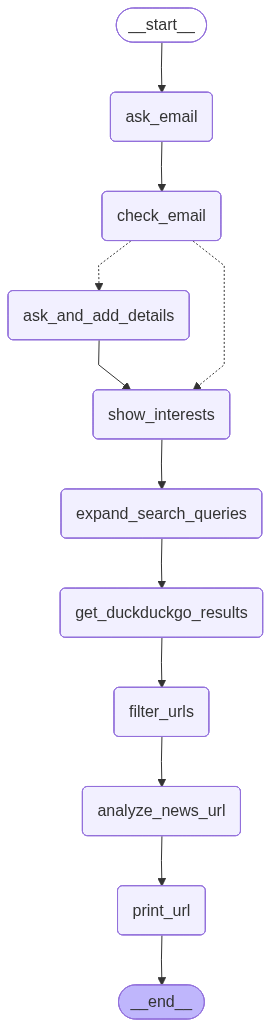

In [37]:
# initialize customer state object to store details
initial_state = CustomerStateV2()

# initalize langgraph workflow with the defined state schema
workflow = StateGraph(state_schema = CustomerStateV2)

# step 1: collect user email and preferences
workflow.add_node("ask_email", ask_email)
workflow.add_node("check_email", check_email)
workflow.add_node("ask_and_add_details", ask_and_add_details)
workflow.add_node("show_interests", show_interests)

# step 2: expand search queries based on user interests
workflow.add_node("expand_search_queries", expand_search_queries)

# fetch search results from DDG
workflow.add_node("get_duckduckgo_results", get_duckduckgo_results)

# step 4: filter urls to only keep relevant
workflow.add_node("filter_urls", filter_urls)

# step 5: filter urls to authentic
workflow.add_node("analyze_news_url", analyze_news_url)

# step 6: print url
workflow.add_node("print_url", print_url)

# def workflow transitions
workflow.set_entry_point("ask_email")

workflow.add_edge("ask_email", "check_email")

# if the email is found, show interests; otherwish, ask for details and then show interests
workflow.add_conditional_edges(
    "check_email",
    lambda result: "show_interests" if result.email_found else "ask_and_add_details",
    {
        "show_interests": "show_interests",
        "ask_and_add_details": "ask_and_add_details"
    }
)

# After collecting details, display user interests
workflow.add_edge("ask_and_add_details", "show_interests")

# Expand search queries based on the collected interests
workflow.add_edge("show_interests", "expand_search_queries")

# Fetch search results using DuckDuckGo
workflow.add_edge("expand_search_queries", "get_duckduckgo_results")

# Filter search results to keep only relevant URLs
workflow.add_edge("get_duckduckgo_results", "filter_urls")

# Analyze news URLs to ensure credibility
workflow.add_edge("filter_urls", "analyze_news_url")

# Print the final output after summarizing content
workflow.add_edge("analyze_news_url", "print_url")

# Set the final output step as the end of the workflow
workflow.add_edge("print_url", END)

# Compile and execute the workflow
graph = workflow.compile()

from IPython.display import Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [38]:
response = graph.invoke(initial_state, langgraph_config)



> Entering new AgentExecutor chain...


INFO:httpx:HTTP Request: POST https://aibe.mygreatlearning.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


I need to construct a SQL query to extract the required information (ID, Name, Email, and Interests) from the database for the specified email address. I will assume the relevant table is named "users" and contains the necessary fields.

Action: sql_db_query  
Action Input: "SELECT ID, Name, Email, Interests FROM users WHERE Email = 'alice.6eb33c45-5@gmail.com';"  
Observation: Error: (sqlite3.OperationalError) no such table: users
[SQL: SELECT ID, Name, Email, Interests FROM users WHERE Email = 'alice.6eb33c45-5@gmail.com';]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
Thought:

INFO:httpx:HTTP Request: POST https://aibe.mygreatlearning.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


It seems that the table "users" does not exist in the database. I need to check the available tables to find the correct one that contains the user information. 

Action: sql_db_query  
Action Input: "SELECT name FROM sqlite_master WHERE type='table';"  
Observation: [('customers',), ('sqlite_sequence',)]
Thought:

INFO:httpx:HTTP Request: POST https://aibe.mygreatlearning.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


The only table available in the database is "customers." I will now check the structure of the "customers" table to see if it contains the fields I need (ID, Name, Email, and Interests).

Action: sql_db_query  
Action Input: "PRAGMA table_info(customers);"  
Observation: [(0, 'id', 'INTEGER', 0, None, 1), (1, 'customer_id', 'TEXT', 1, None, 0), (2, 'name', 'TEXT', 1, None, 0), (3, 'email', 'TEXT', 1, None, 0), (4, 'interests', 'TEXT', 1, None, 0), (5, 'last_updated', 'TIMESTAMP', 0, 'CURRENT_TIMESTAMP', 0)]
Thought:

INFO:httpx:HTTP Request: POST https://aibe.mygreatlearning.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


I have confirmed that the "customers" table contains the necessary fields: id, name, email, and interests. I will now construct a SQL query to extract the required information from the "customers" table for the specified email address.

Action: sql_db_query  
Action Input: "SELECT id, name, email, interests FROM customers WHERE email = 'alice.6eb33c45-5@gmail.com';"  
Observation: [(4, 'Alice', 'alice.6eb33c45-5@gmail.com', '["Politics", "Technology", "Business"]')]
Thought:

INFO:httpx:HTTP Request: POST https://aibe.mygreatlearning.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


I have successfully retrieved the information for the specified email address. The data includes the ID, Name, Email, and Interests.

Final Answer: 
- ID: 4
- Name: Alice
- Email: alice.6eb33c45-5@gmail.com
- Interests: ["Politics", "Technology", "Business"]

> Finished chain.
--- Expand Search Queryies


INFO:httpx:HTTP Request: POST https://aibe.mygreatlearning.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://aibe.mygreatlearning.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://aibe.mygreatlearning.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
/var/folders/3f/dl8h79md0tl8wg6wq4rmkpdw0000gq/T/ipykernel_95102/4283766323.py:14: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
INFO:primp:response: https://duckduckgo.com/?q=latest+breaking+news+in+politics 200


Expanded Search Queries:
 ['"latest breaking news in politics"', '"latest technology news and trends"', '"latest business news trends developments"']
--- Getting DuckDuckGo Results ----
searching for: latest breaking news in politics


INFO:primp:response: https://duckduckgo.com/news.js?l=us-en&o=json&noamp=1&q=latest+breaking+news+in+politics&vqd=4-153942125349049323291900829724663841478&p=-1 200


Raw Response for 'latest breaking news in politics': [{'date': '2025-12-04T00:38:42+00:00', 'title': "CNN shares breaking news alert - and it's not looking good for Pete Hesgeth", 'body': "During the latest segment of CNN, a 'classified' report about Pete Hegseth was revealed, sharing more details about messages that were leaked from a Pentagon group chat", 'url': 'https://www.msn.com/en-us/news/politics/cnn-shares-breaking-news-alert-and-it-s-not-looking-good-for-pete-hesgeth/ar-AA1RFo2k', 'image': 'https://img-s-msn-com.akamaized.net/tenant/amp/entityid/AA1RF4uL.img?w=810&h=539&m=4&q=79', 'source': 'Irish Star'}, {'date': '2025-11-30T11:00:00+00:00', 'title': '5 ways Republicans are breaking with Trump', 'body': 'President Trump is facing increasing resistance from Republicans in Congress to certain proposals and parts of his agenda as he nears the end of his first year back in office. Trump remains the', 'url': 'https://www.msn.com/en-us/news/politics/5-ways-republicans-are-breaking

/var/folders/3f/dl8h79md0tl8wg6wq4rmkpdw0000gq/T/ipykernel_95102/4283766323.py:14: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/var/folders/3f/dl8h79md0tl8wg6wq4rmkpdw0000gq/T/ipykernel_95102/4283766323.py:14: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
INFO:httpx:HTTP Request: POST https://aibe.mygreatlearning.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


--- filter to trustworthy urls ----


INFO:httpx:HTTP Request: POST https://aibe.mygreatlearning.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


[{'url': 'https://www.usatoday.com/story/news/politics/2025/11/20/inside-florida-politics-is-maga-political-base-crumbling/87381348007/', 'body': "During the latest segment of CNN, a 'classified' report about Pete Hegseth was revealed, sharing more details about messages that were leaked from a Pentagon group chat"}, {'url': 'https://www.cnn.com/2025/10/07/politics/republican-lawmaker-records-seized-explained', 'body': 'President Trump is facing increasing resistance from Republicans in Congress to certain proposals and parts of his agenda as he nears the end of his first year back in office. Trump remains the'}]
---FINAL url---
https://www.usatoday.com/story/news/politics/2025/11/20/inside-florida-politics-is-maga-political-base-crumbling/87381348007/


https://www.cnn.com/2025/10/07/politics/republican-lawmaker-records-seized-explained




In [39]:
# Generating final function
import logging
import sys
import os
import builtins

In [40]:
def extract_url_list(addable_dict: AddableValuesDict):
    return [{"url": credible_url.get("url", ""), "content": credible_url.get("content", "")}
            for credible_url in addable_dict.get("credible_urls", [])]

In [41]:
def url_generation_with_agent(email: str,name: str=None,interests:str=None):
    """Starts the workflow with a provided email."""
    # Ensure email is passed correctly to CustomerState
    # Create an instance of CustomerState with email
    def suppress_logs():
        """Disables all logging, print statements, and standard output."""
        logging.basicConfig(level=logging.WARNING, force=True)

        # Silence specific noisy loggers
        for noisy_logger in ["sql agent", "duckduck go search"]:
            logging.getLogger(noisy_logger).setLevel(logging.ERROR)

        # Redirect stdout and stderr to prevent any unwanted print output
        sys.stdout = open(os.devnull, "w")
        sys.stderr = open(os.devnull, "w")

        # Disable print statements
        builtins.print = lambda *args, **kwargs: None

    # Call this function at the start to suppress logs
    suppress_logs()

    initial_state = CustomerStateV2(email=email,name=name,interests=interests)

    # Initialize LangGraph workflow with the defined state schema
    workflow = StateGraph(state_schema=CustomerStateV2)

    # Step 1: Collect user email and preferences
    workflow.add_node("ask_email", ask_email)  # Prompt user for their email
    workflow.add_node("check_email", check_email)  # Check if the email exists in the database
    workflow.add_node("ask_and_add_details", ask_and_add_details)  # Collect name and interests if email is not found
    workflow.add_node("show_interests", show_interests)  # Display the user's interests

    # Step 2: Expand search queries based on user interests
    workflow.add_node("expand_search_queries", expand_search_queries)  # Generate refined search queries

    # Step 3: Fetch search results from DuckDuckGo
    workflow.add_node("get_duckduckgo_results", get_duckduckgo_results)  # Retrieve news articles based on search queries

    # Step 4: Filter URLs to keep only relevant ones
    workflow.add_node("filter_urls", filter_urls)  # Select URLs relevant to the user's interests

    # Step 5: Filter URLs to keep only authentic ones
    workflow.add_node("analyze_news_url", analyze_news_url)  # Check the credibility of news sources

    # Step 6: Print url
    workflow.add_node("print_url", print_url)  # Display the final summarized information

    # Define Workflow Transitions
    workflow.set_entry_point("ask_email")  # Start the workflow by asking for email

    # Transition from asking email to checking if it's in the database
    workflow.add_edge("ask_email", "check_email")

    # If the email is found, show interests; otherwise, ask for details and then show interests
    workflow.add_conditional_edges(
        "check_email",
        lambda result: "show_interests" if result.email_found else "ask_and_add_details"
    )

    # After collecting details, display user interests
    workflow.add_edge("ask_and_add_details", "show_interests")

    # Expand search queries based on the collected interests
    workflow.add_edge("show_interests", "expand_search_queries")

    # Fetch search results using DuckDuckGo
    workflow.add_edge("expand_search_queries", "get_duckduckgo_results")

    # Filter search results to keep only relevant URLs
    workflow.add_edge("get_duckduckgo_results", "filter_urls")

    # Analyze news URLs to ensure credibility
    workflow.add_edge("filter_urls", "analyze_news_url")

    # Print the final output after summarizing content
    workflow.add_edge("analyze_news_url", "print_url")

    # Set the final output step as the end of the workflow
    workflow.add_edge("print_url", END)

    # Compile and execute the workflow
    graph = workflow.compile()

    # Start workflow execution with initial state
    output = graph.invoke(initial_state,langgraph_config)
    final_output=extract_url_list(output)
    formatted_results = []
    for i, result in enumerate(final_output, 1):
        formatted_results.append(f"{i}. {result['url']}\n")

    return "\n".join(formatted_results)

In [42]:
url_generation_with_agent("alice.6eb33c45-5@gmail.com")

'1. https://www.nytimes.com/live/2025/12/03/us/trump-news\n\n2. https://edition.cnn.com/politics/live-news/trump-venezuela-immigration-ukraine-news-11-30-25?post-id=cmilqiy2d00003b6oezld9ktm\n\n3. https://www.usatoday.com/story/news/politics/2025/11/20/inside-florida-politics-is-maga-political-base-crumbling/87381348007/\n'

In [49]:
with gr.Blocks() as iface:
    gr.Markdown("## Ai-Powered News Fetcher")

    with gr.Tabs():
        with gr.Tab("For Existing Members"):
            gr.Markdown("Enter your email id")
            with gr.Row():
                with gr.Column(scale = 1):
                    email_input_wo = gr.Textbox(label = "enter your email id", placeholder = "e.g., abc@gmail.com")

                    with gr.Row():
                        submit_button_wo = gr.Button("Submit", variant="primary")
                        cancel_button_wo = gr.Button("Cancel", variant="stop")

                with gr.Column(scale=2):
                    output_wo = gr.Textbox(label = "Latest News", interactive = False)
            
            submit_button_wo.click(fn=url_generation_with_agent, inputs=email_input_wo, outputs=output_wo)
            cancel_button_wo.click(fn=lambda: "", inputs=[], outputs=output_wo)

        with gr.Tab("For New Members"):
            gr.Markdown("Enter an order number and your query.")
            with gr.Row():
                with gr.Column(scale=1):
                    email_input_g = gr.Textbox(label="Enter Your Email Id", placeholder="e.g., abc@example.com")
                    name_input_g = gr.Textbox(label="Enter Your Name", placeholder="e.g., Mark")
                    interest_input_g = gr.Textbox(
                        label="Enter Your Interest separated by commas ','",
                        placeholder="e.g., Generative AI"
                    )


                    with gr.Row():
                        submit_button_g = gr.Button("Submit", variant="primary")
                        cancel_button_g = gr.Button("Cancel", variant="stop")

                with gr.Column(scale=2):
                    output_g = gr.Textbox(label="Latest News", interactive=False)

            submit_button_g.click(fn=url_generation_with_agent, inputs=[email_input_g, name_input_g,interest_input_g], outputs=output_g)
            cancel_button_g.click(fn=lambda: "", inputs=[], outputs=output_g)

iface.launch(share=True)